# Advanced Dataframes

In this lesson we will continue working with pandas dataframes, and explore some more complex dataframe manipulations.

In [1]:
import pandas as pd
import numpy as np

np.random.seed(123)

In [1]:
# Create list of values for names column.

students = ['Sally', 'Jane', 'Suzie', 'Billy', 'Ada', 'John', 'Thomas',
            'Marie', 'Albert', 'Richard', 'Isaac', 'Alan']

# Randomly generate arrays of scores for each student for each subject.
# Note that all the values need to have the same length here.

math_grades = np.random.randint(low=60, high=100, size=len(students))
english_grades = np.random.randint(low=60, high=100, size=len(students))
reading_grades = np.random.randint(low=60, high=100, size=len(students))

In [1]:
# Construct the DataFrame using the above lists and arrays.

df = pd.DataFrame({'name': students,
                   'math': math_grades,
                   'english': english_grades,
                   'reading': reading_grades,
                   'classroom': np.random.choice(['A', 'B'], len(students))})

## Creating Dataframes

### From Lists and Dictionaries

There are several ways to create dataframes, we've already seen how we can create a dataframe from a dictionary:

In [2]:
pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})

,A,B
0,1,4
1,2,5
2,3,6


The keys in the passed dictionary will be the column names, and the values are the data points that make up each column.

We can also create dataframes from a 2d data structure, either a numpy array or a list of lists:

In [3]:
pd.DataFrame([[1, 2, 3], [4, 5, 6]])

,0,1,2
0,1,2,3
1,4,5,6


In [4]:
array = np.array([[1, 2, 3], [4, 5, 6]])

pd.DataFrame(array, columns=['a', 'b', 'c'])

,a,b,c
0,1,2,3
1,4,5,6


Notice here that we had to specify the names of the columns ourselves.

### From Text Files

The most commonly used function to data from an external text file is `read_csv`. Two other commonly used functions are `read_table`, for less structured files that are still tabular, and `read_json`, for data stored as JSON.

There are many other `read_` functions, but `read_csv` will be the most commonly used one.

See the documentation for the individual functions for customizing how the data is read into a dataframe.

### From SQL

We can use the `read_sql` method to create a dataframe based on the results of a SQL query. To do this, we need to tell pandas how to connect to the database we are querying. The way we communicate this to pandas is with a specially formatted *connection string*.

In addition, whenever we want to connect to a database from our python code (other programming languages are similar), we will need a **driver**, a bit of software that handles the details of the database connection.

In order to connect to mysql, we'll install the `mysqlclient` and `pymysql` driver packages:

`python -m pip install mysqlclient pymysql`

Once those are installed, we can create the connection string. In general, database connection urls will have this format:

```
protocol://[user[:password]@]hostname/[database_name]
```

Here's an example of what one would look like:

```
mysql+pymysql://codeup:p@assw0rd@123.123.123.123/some_db
```

Another thing we need to consider is that we don't want to publish our database credentials to github, however, we will need access to these values in our code in order to create the connection string defined above.

In order to accomplish this, we can define several variables in a file named `env.py` that contain the sensitive data, add `env.py` to our `.gitignore` file, and then import those values into another script. 

**Be 100% sure to add `env.py` to this specific repository's `.gitignore` file, even and especially, if you have already added `env.py` to your global .gitignore file. This will protect the env file for people who clone this project (like collaborators)**

In [5]:
from env import host, user, password

url = f'mysql+pymysql://{user}:{password}@{host}/employees'

Once this url is defined, we can use it with the `read_sql` function to have pandas treat the results of a SQL query as a dataframe.

In [6]:
pd.read_sql('SELECT * FROM employees LIMIT 5 OFFSET 50', url)

,emp_no,birth_date,first_name,last_name,gender,hire_date
0,10051,1953-07-28,Hidefumi,Caine,M,1992-10-15
1,10052,1961-02-26,Heping,Nitsch,M,1988-05-21
2,10053,1954-09-13,Sanjiv,Zschoche,F,1986-02-04
3,10054,1957-04-04,Mayumi,Schueller,M,1995-03-13
4,10055,1956-06-06,Georgy,Dredge,M,1992-04-27


It is common to have longer SQL queries that we want to read into python, and an example of how we might break a query into several lines is below:

In [7]:
sql = '''
SELECT
    emp_no,
    first_name,
    last_name
FROM employees
WHERE gender = 'F'
LIMIT 5
OFFSET 200
'''

pd.read_sql(sql, url)

,emp_no,first_name,last_name
0,10513,Yuichiro,Schicker
1,10519,Yonghoan,Alencar
2,10522,Marke,Cesareni
3,10524,Shigehiro,Cincotta
4,10526,Kwangho,Theuretzbacher


!!!danger "Passwords and Sensitive Information"
    Don't add and commit files with passwords or other sensitive information in them to a git repository!

In [8]:
query = '''
SELECT
    t.title as title,
    d.dept_name as dept_name
FROM titles t
JOIN dept_emp USING (emp_no)
JOIN departments d USING (dept_no)
'''

employees = pd.read_sql(query, url)

## Aggregating

The `.agg` function lets us specify a way to aggregate a series of numerical values.

In [9]:
df.reading.agg('min')

67

While on the surface this seems pretty simple, `.agg` is capable of providing more detailed aggregations:

In [10]:
df[['english', 'reading', 'math']].agg(['mean', 'min', 'max'])

,english,reading,math
mean,77.666667,86.5,84.833333
min,62.000000,67.0,62.000000
max,99.000000,98.0,98.000000


### Grouping

The `.groupby` method is used to created a grouped object, which we can then apply an aggregation on. For example, if we wanted to know the highest math grade from each classroom:

In [11]:
df.groupby('classroom').math.max()

classroom
A    94
B    98
Name: math, dtype: int64

We can use `.agg` here to, to see multiple aggregations:

In [12]:
df.groupby('classroom').math.agg(['min', 'mean', 'max'])

,min,mean,max
classroom,,,
A,62,82.625,94
B,79,89.250,98


We can group by multiple columns as well. To demonstrate, we'll create a boolean column named `passing_math`, then group by the combination of our new feature and the classroom, and calculate the average reading grade and number of individuals in each subgroup:

In [13]:
(df
 .assign(passing_math=df.math.apply(lambda n: 'failing' if n < 70 else 'passing'))
 .groupby(['passing_math', 'classroom']) # note we now pass a list of columns
 .reading
 .agg(['mean', 'count']))

mean  count
passing_math classroom                  
failing      A          87.000000      2
passing      A          87.166667      6
             B          85.250000      4

This means there are 2 students failing math in classroom A with an average reading grade of 87, 6 students passing math in classroom A with an average reading grade of 87.16, and 4 students passing math in classroom B with an average reading grade of 85.25.

The `transform` method can be used to produce a series with the same length of the original dataframe where each value represents the aggregation from the grouped by subgroup. For example, if we wanted to know the average math grade for each classroom, and add this data back to our original dataframe:

In [14]:
df.assign(avg_math_score_by_classroom=df.groupby('classroom').math.transform('mean'))

,name,math,english,reading,classroom,avg_math_score_by_classroom
0,Sally,62,85,80,A,82.625
1,Jane,88,79,67,B,89.250
2,Suzie,94,74,95,A,82.625
3,Billy,98,96,88,B,89.250
4,Ada,77,92,98,A,82.625
5,John,79,76,93,B,89.250
6,Thomas,82,64,81,A,82.625
7,Marie,93,63,90,A,82.625
8,Albert,92,62,87,A,82.625
9,Richard,69,80,94,A,82.625


In [15]:
df.groupby('classroom').reading.describe()

,count,mean,std,min,25%,50%,75%,max
classroom,,,,,,,,
A,8.0,87.125,8.887190,72.0,80.75,88.5,94.25,98.0
B,4.0,85.250,12.392874,67.0,82.75,90.5,93.00,93.0


## Merging and Joining

Pandas provides several ways to combine dataframes together. We will look at two of them

- `pd.concat`: to combine dataframes vertically, the way CONCAT would in SQL
- `pd.merge`: to combine dataframes horizontally, the way a SQL JOIN would

### `concat`

When concatenating dataframes vertically, we basically are just adding more rows to an existing dataframe. In this case, the dataframes we are putting together should have the same column names[^1].

[^1]:
    We can concatenate dataframes with different column names, but generally this is not the behavior we want, as pandas will fill in a lot of null values into the resulting dataframe. The exception to this is if the dataframes are aligned on their index (i.e. the labels for each row), then we can provide the `axis=1` keyword argument to `pd.concat` to merge the dataframes horizontally.

In [16]:
df1 = pd.DataFrame({'a': [1, 2, 3]})
df2 = pd.DataFrame({'a': [4, 5, 6]})

df1

,a
0,1
1,2
2,3


In [17]:
df2

,a
0,4
1,5
2,6


In [18]:
pd.concat([df1, df2])

,a
0,1
1,2
2,3
0,4
1,5
2,6


Note that the indices are preserved on the resulting dataframe, we could call the `reset_index` method if we wanted these to be sequential.

### `merge`

Merging is like a `JOIN` in SQL. We'll use a similar example to the one we used in the SQL module to illustrate:

In [19]:
users = pd.DataFrame({
    'id': [1, 2, 3, 4, 5, 6],
    'name': ['bob', 'joe', 'sally', 'adam', 'jane', 'mike'],
    'role_id': [1, 2, 3, 3, np.nan, np.nan]
})
users

,id,name,role_id
0,1,bob,1.0
1,2,joe,2.0
2,3,sally,3.0
3,4,adam,3.0
4,5,jane,NaN
5,6,mike,NaN


In [20]:
roles = pd.DataFrame({
    'id': [1, 2, 3, 4],
    'name': ['admin', 'author', 'reviewer', 'commenter']
})
roles

,id,name
0,1,admin
1,2,author
2,3,reviewer
3,4,commenter


The `merge` function will accept the left and right dataframes, and two keyword arguments, `left_on`, and `right_on` that are used to indicate the columns that are keys that will be used to merge the dataframes together. In addition, the `how` keyword argument is used to define what type of JOIN we want to do; one of `inner`, `left`, `right`, or `outer`.

In [21]:
pd.merge(users, roles, left_on='role_id', right_on='id', how='left')

,id_x,name_x,role_id,id_y,name_y
0,1,bob,1.0,1.0,admin
1,2,joe,2.0,2.0,author
2,3,sally,3.0,3.0,reviewer
3,4,adam,3.0,3.0,reviewer
4,5,jane,NaN,NaN,NaN
5,6,mike,NaN,NaN,NaN


Notice that we have duplicate column names in the resulting dataframe. By default, pandas will add a suffix of `_x` to any columns in the left dataframe that are duplicated, and `_y` to any columns in the right dataframe that are duplicated. We can customize this behavior with the `suffixes` keyword argument, or we can simply rename the columns before the merge:

In [22]:
pd.merge(
    users.rename(columns={'id': 'user_id', 'name': 'username'}),
    roles.rename(columns={'name': 'role_name'}),
    left_on='role_id', right_on='id', how='left')

,user_id,username,role_id,id,role_name
0,1,bob,1.0,1.0,admin
1,2,joe,2.0,2.0,author
2,3,sally,3.0,3.0,reviewer
3,4,adam,3.0,3.0,reviewer
4,5,jane,NaN,NaN,NaN
5,6,mike,NaN,NaN,NaN


## Reshaping

We will talk about reshaping operations in more detail when we discuss tidy data, but for now we will focus on a couple common operations that can be used to summarize our data by different subgroups:

- `pd.crosstab`
- `.pivot_table`

For an example of `crosstab`, we will count the number of students passing math in each classroom.

First we will create a column that contains either `passing` or `failing` depending on the student's math grade:

In [23]:
df['passing_math'] = df.math.apply(lambda n: 'passing' if n >= 70 else 'failing')

Next we'll use the `pd.crosstab` function to count the number of occurances of each subgroup (i.e. each unique combination of classroom and whether or note the student is passing):

In [24]:
pd.crosstab(df.passing_math, df.classroom)

classroom,A,B
passing_math,,
failing,2,0
passing,6,4


The `crosstab` function will let us view the numbers as a percentage of the total as well, with the `normalize` keyword argument:

In [25]:
pd.crosstab(df.passing_math, df.classroom, normalize=True)

classroom,A,B
passing_math,,
failing,0.166667,0.000000
passing,0.500000,0.333333


We can also view subtotals with the `margins` keyword argument.

In [26]:
pd.crosstab(df.passing_math, df.classroom, margins=True)

classroom,A,B,All
passing_math,,,
failing,2,0,2
passing,6,4,10
All,8,4,12


For an example using the `pivot_table` method, we'll calculate the average math grade for the combination of classroom and whether each student is passing or failing math.

In [27]:
df.pivot_table(values='math', index='classroom', columns='passing_math', aggfunc='mean')

passing_math,failing,passing
classroom,,
A,65.5,88.333333
B,NaN,89.250000


Here we use the `.pivot_table` method to create our summary. This method produces output similar to an excel pivot table. We must supply 3 things here:

- the values we are aggregating
- which values will make up the rows (the `index`)
- which values will make up the columns
- an aggregation method (`aggfunc`); if we can omit this, and `mean` will be used by default

Note that for the `values`, `index`, and `columns`, we could also supply a list of column names.

### Another Example

Here we'll create a dataframe that represents various orders at a restaurant.

In [28]:
n = 40

orders = pd.DataFrame({
    'drink': np.random.choice(['Tea', 'Water', 'Water'], n),
    'meal': np.random.choice(['Curry', 'Yakisoba Noodle', 'Pad Thai'], n),
})

prices = {
    'Yakisoba Noodle': 9,
    'Curry': 11,
    'Pad Thai': 10,
    'Tea': 2,
    'Water': 0,
}

# The .map method lets us use the above dictionary to calculate the total price for an order
orders['bill'] = orders.drink.map(prices) + orders.meal.map(prices)

orders.tail(5)

,drink,meal,bill
35,Water,Curry,11
36,Tea,Curry,13
37,Water,Pad Thai,10
38,Water,Curry,11
39,Water,Pad Thai,10


Let's take a look at how many orders have each combination of meal and drink:

In [29]:
pd.crosstab(orders.drink, orders.meal)

meal,Curry,Pad Thai,Yakisoba Noodle
drink,,,
Tea,3,4,5
Water,9,10,9


In [30]:
pd.crosstab(orders.drink, orders.meal, normalize=True, margins=True)

meal,Curry,Pad Thai,Yakisoba Noodle,All
drink,,,,
Tea,0.075,0.10,0.125,0.3
Water,0.225,0.25,0.225,0.7
All,0.300,0.35,0.350,1.0


And let's find out the bill amount for each combination: 

In [31]:
orders.pivot_table('bill', 'drink', 'meal')

meal,Curry,Pad Thai,Yakisoba Noodle
drink,,,
Tea,13,12,11
Water,11,10,9


It's interesting to note that we could find the same information with a multi-level group by:

In [32]:
orders.groupby(['drink', 'meal']).bill.mean()

drink  meal           
Tea    Curry              13
       Pad Thai           12
       Yakisoba Noodle    11
Water  Curry              11
       Pad Thai           10
       Yakisoba Noodle     9
Name: bill, dtype: int64

The choice between group by and a pivot table here is mostly asthetic, and you should use whichever makes more sense to you with the problem at hand. 

## More Dataframe Features

### Indices

A dataframe's *index* is a way to label each row.

<AxesSubplot:ylabel='Frequency'>

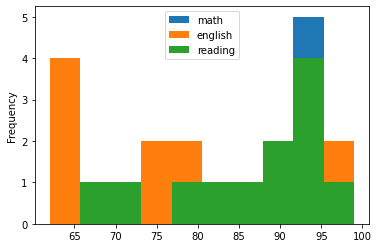

In [33]:
df.set_index('classroom').plot.hist()

We'll revisit the concept of indices in more depth when we talk about time series data, but it is good to be familiar with the concept for now.

### `.pipe`

The `.pipe` method allows chains of functions that accept and return dataframes to be applied to a dataframe, and extra arguments to those functions to be specified.

In [34]:
def calculate_avg_grade(df):
    avg = (df.math + df.english + df.reading) / 3
    return df.assign(average_grade=avg)

df.pipe(calculate_avg_grade)

,name,math,english,reading,classroom,passing_math,average_grade
0,Sally,62,85,80,A,failing,75.666667
1,Jane,88,79,67,B,passing,78.000000
2,Suzie,94,74,95,A,passing,87.666667
3,Billy,98,96,88,B,passing,94.000000
4,Ada,77,92,98,A,passing,89.000000
5,John,79,76,93,B,passing,82.666667
6,Thomas,82,64,81,A,passing,75.666667
7,Marie,93,63,90,A,passing,82.000000
8,Albert,92,62,87,A,passing,80.333333
9,Richard,69,80,94,A,failing,81.000000


### `.loc` and `.iloc`

We can use `.iloc` to subset rows or columns using a numerical index. For example, to select the first 3 rows:

In [35]:
df.iloc[:3]

,name,math,english,reading,classroom,passing_math
0,Sally,62,85,80,A,failing
1,Jane,88,79,67,B,passing
2,Suzie,94,74,95,A,passing


We can also specify which columns we want to select:

In [36]:
df.iloc[:3, 1:3]

,math,english
0,62,85
1,88,79
2,94,74


Here we select the first 3 rows (everything up to but not including the index of 3), and the second and third columns (starting from the index of 1 up to but not including the index of 3).

Similarly, `.loc` lets us obtain values by a named index:

In [37]:
df.loc[:, 'math':'reading'].head(4)

,math,english,reading
0,62,85,80
1,88,79,67
2,94,74,95
3,98,96,88


The above code asks pandas for all of the rows from the dataframe (`:`), and all of the columns from `math` to `reading`. From the resulting dataframe, we call the `.head` method to get the first 4 rows.

### Transposing

In [38]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11
name,Sally,Jane,Suzie,Billy,Ada,John,Thomas,Marie,Albert,Richard,Isaac,Alan
math,62,88,94,98,77,79,82,93,92,69,92,92
english,85,79,74,96,92,76,64,63,62,80,99,62
reading,80,67,95,88,98,93,81,90,87,94,93,72
classroom,A,B,A,B,A,B,A,A,A,A,B,A
passing_math,failing,passing,passing,passing,passing,passing,passing,passing,passing,failing,passing,passing


## Exercises

Run `python -m pip install mysqlclient pymysql` from your terminal to install pymysql and the mysqlclient.

Create a notebook or python script named `advanced_dataframes` to do your work in for this exercise.

For the following exercises, you'll need to load several datasets using the `pydataset` library. (If you get an error when trying to run the import below, use `pip` to install the `pydataset` package.)

In [39]:
from pydataset import data

When the instructions say to load a dataset, you can pass the name of the dataset as a string to the `data` function to load the dataset. You can also view the documentation for the data set by passing the `show_doc` keyword argument.

In [40]:
mpg = data('mpg') # load the dataset and store it in a variable
# data('mpg', show_doc=True) # view the documentation for the dataset

1. Load the `mpg` dataset. Read the documentation for it, and use the data to answer these questions:

    - On average, which manufacturer has the best miles per gallon?
    - How many different manufacturers are there?
    - How many different models are there?
    - Do automatic or manual cars have better miles per gallon?

1. Joining and Merging

    Copy the `users` and `roles` dataframes from the examples above. What do you think a `right` join would look like? An `outer` join?
    What happens if you drop the foreign keys from the dataframes and try to merge them?

1. Getting data from SQL databases 

    1. Create a function named `get_db_url`. It should accept a username, hostname, password, and database name and return a url formatted like in the examples in this lesson.
    1. Use your function to obtain a connection to the `employees` database.
    1. Once you have successfully run a query:
        - Intentionally make a typo in the database url. What kind of error message do you see?
        - Intentionally make an error in your SQL query. What does the error message look like?
    1. Read the `employees` and `titles` tables into two separate dataframes
    1. Visualize the number of employees with each title.
    1. Join the `employees` and `titles` dataframes together.
    1. Visualize how frequently employees change titles.
    1. For each title, find the hire date of the employee that was hired most recently with that title.
    1. Write the code necessary to create a cross tabulation of the number of titles by department. (Hint: this will involve a combination of SQL and python/pandas code)

1. Use your `get_db_url` function to help you explore the data from the `chipotle` database. Use the data to answer the following questions:

    - What is the total price for each order?
    - What are the most popular 3 items?
    - Which item has produced the most revenue?

### Extra Pandas Exercises and Resources
- https://www.w3resource.com/python-exercises/pandas/index.php
- https://towardsdatascience.com/20-pandas-functions-that-will-boost-your-data-analysis-process-f5dfdb2f9e05
- https://github.com/guipsamora/pandas_exercises
- https://github.com/ajcr/100-pandas-puzzles

### More Practice!

For even more practice with pandas, you can do the exercises from the SQL module, but instead of using SQL to do the aggregation, sorting, joining, etc, use pandas. That is, read the data from all of the tables into pandas dataframes and manipulate the dataframes.